In [94]:
# %pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score 
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import differential_evolution, minimize
import glob
import os

In [95]:
def import_dfs_c():
    # Path to the folder containing CSV files
    folder_path = '../dados/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '5*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        print(file)
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    
    
    # HARDCODED
    data_frames.append(pd.read_csv('../dados/nh60ab80.csv'))
    return data_frames


In [96]:
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = 'DadosRN/data_collection/ph6t25/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    print(csv_files)
    # Initialize an empty list to hold dataframes
    data_frames = []

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']


    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file,index_col=False)  
        vel = df.columns[-1]
        schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm',str(vel)]
        df = df[schema]  # Reorder columns to match the schema
        data_frames.append(df)
    return data_frames

data_frames = import_dfs()
data_frames_c = import_dfs_c()
x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

['DadosRN/data_collection/ph6t25\\amox_hid.csv', 'DadosRN/data_collection/ph6t25\\amox_sis.csv', 'DadosRN/data_collection/ph6t25\\ester_hid.csv', 'DadosRN/data_collection/ph6t25\\micro_amox_hid.csv', 'DadosRN/data_collection/ph6t25\\micro_ester_hid.csv']
../dados\5.100nh40ab80.csv
../dados\5.102nh20ab40.csv
../dados\5.103nh40ab30.csv
../dados\5.106nh100ab40.csv
../dados\5.107nh55ab55.csv
../dados\5.109nh5ab55.csv
../dados\5.110nh10ab55.csv
../dados\5.112nh78ab35.csv
../dados\5.46nh30ab30.csv
../dados\5.47nh5ab80.csv
../dados\5.48nh20ab80.csv
../dados\5.80nh12ab40.csv
../dados\5.81nh5ab30.csv


In [97]:
kcat1        = 0.181
kcat2        = 0.395
Km1          = 5.449
Km2          = 1.694
Tmax         = 0.824
Ken          = 7.947
kAB          = 0.682
kAN          = 1.989
kAOH         = 9.856
kNH          = 9.763

P = np.zeros(10)
P[0]   = kcat1    
P[1]   = kcat2    
P[2]   = Km1      
P[3]   = Km2      
P[4]   = Tmax     
P[5]   = Ken      
P[6]   = kAB      
P[7]   = kAN      
P[8]   = kAOH     
P[9]  = kNH 

labels_all = ['kcat1',
    'kcat2',
    'Km1',
    'Km2',  
    'Tmax', 
    'Ken',  
    'kAB',  
    'kAN',  
    'kAOH', 
    'kNH']

labels_hid_amox = [
    'kcat2',
    'Km2',   
    'kAB', 
    'kNH'  
    'kAOH']

labels_sis_amox = [
    'kcat1',
    'km1',
    'kAN',
    'kAOH',
    'Tmax',
    'Ken',
]
p_hid_amox = np.array([P[1],P[3],P[6],P[9],P[8]])
p_sis_amox = np.array([P[0],P[2],P[7],P[9],P[4],P[5]])

In [98]:
def ester_consumption(p,ic):
    kcat1 = p[0]
    km1 = p[1]
    kAN = p[2]
    kAOH = p[3]
    
    terms = np.zeros(2)
    i = 0
    cez = 1

    can = ic[1]
    if can != 0 and kAN != 0:
        terms[i] = can/kAN

    cab = ic[0]

    caoh = ic[3]
    if caoh != 0 and kAOH != 0:
        terms[i] = caoh/kAOH

    up = kcat1*cab*cez
    down = km1 + np.sum(km1*terms) + cab
    
    return up/down

In [99]:
def calculate_amox_sis(p,ic):
    kcat1 = p[0]
    km1 = p[1]
    kAN = p[2]
    kAOH = p[3]
    Tmax = p[4]
    Ken = p[5]

    cnh = ic[2]
    X = cnh/(Ken + cnh)
    
    return ester_consumption(p,ic)*Tmax*X

In [100]:
def calculate_ester_hid(p,ic):
    return ester_consumption(p,ic) - calculate_amox_sis(p,ic)

In [101]:
def calculate_amox_hid(p,ic):
    kcat2 = p[0]
    km2 = p[1]
    kAB = p[2]
    kNH = p[3]
    kAOH = p[4]
    terms = np.zeros(3)
    i = 0
    cez = 1
    can = ic[1]

    cab = ic[0]
    if cab != 0 and kAB != 0:
        terms[i] = cab/kAB

    cnh = ic[2]
    if cnh != 0 and kNH != 0:
        terms[i] = cnh /kNH
    
    caoh = ic[3]
    if caoh != 0 and kAOH != 0:
        terms[i] = caoh/kAOH

    up = kcat2*can*cez
    down = km2 + np.sum(km2*terms) + can
    cez = 1
    
    return up/down

In [102]:
def calculate_error_all(p,print_error=False):
    kcat1  = p[0]    
    kcat2  = p[1]   
    Km1    = p[2]     
    Km2    = p[3]     
    Tmax   = p[4]     
    Ken    = p[5]     
    kAB    = p[6]     
    kAN    = p[7]     
    kAOH   = p[8]     
    kNH    = p[9]
    
    total_error_amoxh = 0
    for row in data_frames[0].to_numpy():
        ic = row[:-1]
        target = row[-1]
        p_hid_amox = np.array([p[1],p[3],p[6],p[9],p[8]])
        pred = calculate_amox_hid(p_hid_amox,ic)
        total_error_amoxh += (target - pred)**2
        #print(ic, ':', target, '=', pred,'error:',(target - pred)**2)

    total_error_amoxs = 0
    for row in data_frames[1].to_numpy():
        ic = row[:-1]
        target = row[-1]
        p_sis_amox = np.array([p[0],p[2],p[7],p[9],p[4],p[5]])
        pred = calculate_amox_sis(p_sis_amox,ic)
        total_error_amoxs += (target - pred)**2
        #print(ic, ':', target, '=', pred,'error:',(target - pred)**2)
    
    total_error_esterh = 0
    for row in data_frames[2].to_numpy():
        ic = row[:-1]
        target = row[-1]
        p_sis_amox = np.array([p[0],p[2],p[7],p[9],p[4],p[5]])
        pred = calculate_amox_hid(p_sis_amox,ic)
        total_error_esterh += (target - pred)**2
        #print(ic, ':', target, '=', pred,'error:',(target - pred)**2)
    total_error = total_error_esterh + total_error_amoxh + total_error_amoxs
    if print_error:
        print(f"ester_h: {total_error_esterh}\namox_h: {total_error_amoxh}\namox_s: {total_error_amoxs}\ntotal: {total_error}",end='\r\r\r')
        for name,par in zip(labels_all,p):
            print(name,': ',par)
    #print(total_error,end='\r')
    return total_error
calculate_error_all(P)    

1.4744768192378308

In [103]:
all_par_sets = []
all_methods = ['Powell','Nelder-Mead','L-BFGS-B','TNC']
for method in all_methods:
    options = {'maxiter':2000}
    record = []
    all_error = []

    boundaries = [(0,3), # Kcat1
                (0,3), # Kcat2
                (0,20), # Km1
                (0,20), # Km2
                (0,1), # Tmax
                (0,50), # Ken
                (0,5000), # kAB
                (0,5000), # kAN
                (0,5000), # kAOH
                (0,5000), # kNH
                ]

    result = minimize(calculate_error_all, P, method=method,bounds=boundaries,options=options,tol=0.0000001)

    # Optimized parameters

    optimized_parameters = result.x
    #print("Previous parameters:", P)
    #print("Optimized Parameters:", optimized_parameters)
    P_new = optimized_parameters
    all_par_sets.append(P_new)
    print(method,':')
    calculate_error_all(P_new,print_error=True)
    # Optimized Parameters: [ 0.3552162   2.          0.46925464 22.59815911  0.56458396]


Powell :
ester_h: 0.1702629757982556
amox_h: 0.5678542862146179
amox_s: 0.038813199504620706
kcat1 :  0.1594350673639785
kcat2 :  0.34411401629988203
Km1 :  19.999999992396397
Km2 :  3.4317981146025445
Tmax :  0.8778958277743588
Ken :  5.33042286048152
kAB :  0.857637743862697
kAN :  4999.9999999445645
kAOH :  1.1328774826876167
kNH :  59.12725001368307


C:\Users\artur\AppData\Local\Temp\ipykernel_5048\3879340056.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return up/down


Nelder-Mead :
ester_h: 0.1640583289788906
amox_h: 0.5248342139133579
amox_s: 0.08152453051238007
kcat1 :  0.09021223189586536
kcat2 :  0.4106471637023469
Km1 :  0.0007535212580647007
Km2 :  4.904607185146663
Tmax :  0.7780316773244373
Ken :  1.3092127780657496
kAB :  0.7992329755194959
kAN :  1.5011803196799665
kAOH :  1.1470770314757415
kNH :  29.774753121109974
L-BFGS-B :
ester_h: 0.17445720373238524
amox_h: 0.4707455164111268
amox_s: 0.038814704209813415
kcat1 :  0.1944128574772717
kcat2 :  0.5309040623850119
Km1 :  20.0
Km2 :  14.365300754534521
Tmax :  0.7236701168004324
Ken :  5.485030335421498
kAB :  2.155341144803748
kAN :  37.13442643250064
kAOH :  2.590416931422549
kNH :  135.59438900390313


C:\Users\artur\AppData\Local\Temp\ipykernel_5048\925763179.py:20: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(calculate_error_all, P, method=method,bounds=boundaries,options=options,tol=0.0000001)


TNC :
ester_h: 0.16824585495443173
amox_h: 0.5443350930245344
amox_s: 0.05434507895093001
kcat1 :  0.13098321522762002
kcat2 :  0.3740521200720097
Km1 :  5.537153326446071
Km2 :  3.2860614788343936
Tmax :  0.8254735671096038
Ken :  7.827212221162856
kAB :  0.6994824441831042
kAN :  89.27657990167518
kAOH :  0.8124455130555361
kNH :  35.94299806529989


# Test graphs

In [104]:
def enzymic_amox(t, y, kcat1, kcat2, Km1, Km2, Tmax, Ken, kAB, kAN, kAOH, kNH):
    FAB = 0
    FNH = 0 

    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    Cez = 1  # Assuming a constant value for Cez if not provided

    # Consumo de ester
    VAB = (kcat1 * CAB * Cez) / ((Km1 * (1 + (CAN/kAN) + (CAOH/kAOH))) + CAB)
    
    # Hidrolise de amoxicilina
    VAN = (kcat2 * CAN * Cez) / ((Km2 * (1 + (CAB/kAB) + (CNH/kNH) + (CAOH/kAOH))) + CAN)
    
    # Enzima saturada com 6-apa
    X = CNH / (Ken + CNH)
    
    # Sintese enzimatica
    VS = VAB * Tmax * X

    # Hidrolise de ester
    Vh1 = (VAB - VS) 

    dy = np.zeros(4)

    # C. ester
    dy[0] = (-(VS - VAN) - (Vh1 + VAN)) + FAB 
    
    # C. amox
    dy[1] = VS - VAN                        
    
    # C. 6-apa
    dy[2] = -(VS - VAN) + FNH                
    
    # C. POHPG
    dy[3] = Vh1 + VAN
    
    return dy


In [105]:
def ode15s_amox(P, CI, t):
    try:
        sol = solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan)

In [106]:
from sklearn.metrics import root_mean_squared_error,r2_score
import seaborn as sns
def mass_deviation(model_output, experimental_data):
    
    exp_mass = np.sum(model_output, axis=1)    
    model_mass = np.sum(experimental_data, axis=1)

    mass_deviation = np.sum(np.abs(exp_mass - model_mass))
    return mass_deviation
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-k','-k','-k','-k']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-5, val_x[:, idx].max()+5])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

def eval_all(P_new):
    total_error = 0
    surface_error = np.zeros((len(data_frames_c),3)) # columns = mse error, ester init, apa init 
    total_mass_error = 0
    for idx,df in enumerate(data_frames_c):
        x_target = df.loc[:,x_names].to_numpy()
        t_target = df['apa_t'].to_numpy()
        
        ic = x_target[0]
        surface_error[idx,1] = ic[0] # ester
        surface_error[idx,2] = ic[2] # apa
        
        t_model = np.linspace(t_target[0],t_target[-1],40)
        
        sol = ode15s_amox(P_new,ic,t_model)
        sol_val = ode15s_amox(P_new,ic,t_target).T

        error = root_mean_squared_error(x_target, sol_val)
        mass_error = mass_deviation(sol_val,x_target)
        r2 = r2_score(x_target,sol_val)

        surface_error[idx,0] = error

        total_error += error
        total_mass_error += mass_error
        #print(ic)
        #print(f'Error {ic}: {error}\tmass: {mass_error}\tr2: {r2}')

        x_model = sol.T
        #model_eval(x_model,t_model,x_target,t_target)
    surfacedf = pd.DataFrame(surface_error,columns=['RMSE','Ester','APA'])
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=surfacedf, x='Ester', y='APA', size='RMSE', hue='RMSE', sizes=(20, 200),legend='full')
    plt.legend(title='Error Value', loc='upper right', bbox_to_anchor=(-0.15, 1))
    #sns.heatmap(surfacedf,annot=True,fmt=".3f")
    print(f'Total error: {total_error}\tmass error:{total_mass_error}')
    return total_error,total_mass_error
#eval_all(P_new)


Powell

Total error: 63.771672609475864	mass error:208.3329012799784

Nelder-Mead

Total error: 65.91566284152178	mass error:474.7763379921662

L-BFGS-B

Total error: 48.4286014123344	mass error:214.83133494899906

TNC

Total error: 53.34112697027456	mass error:207.2493592592112


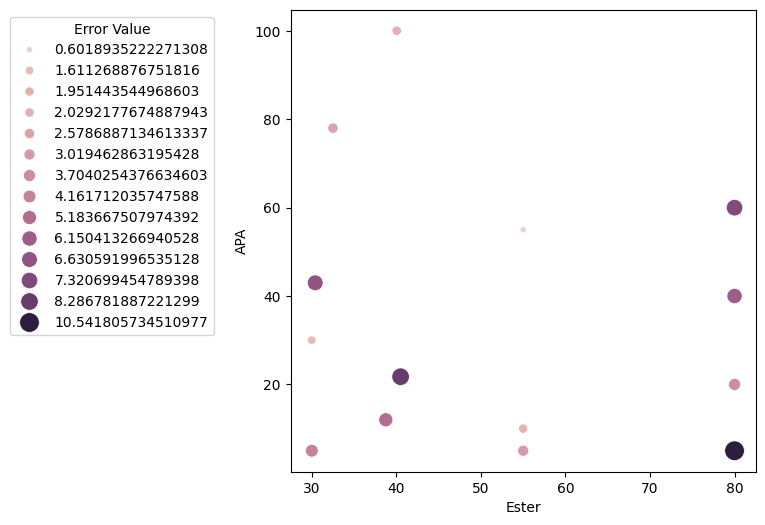

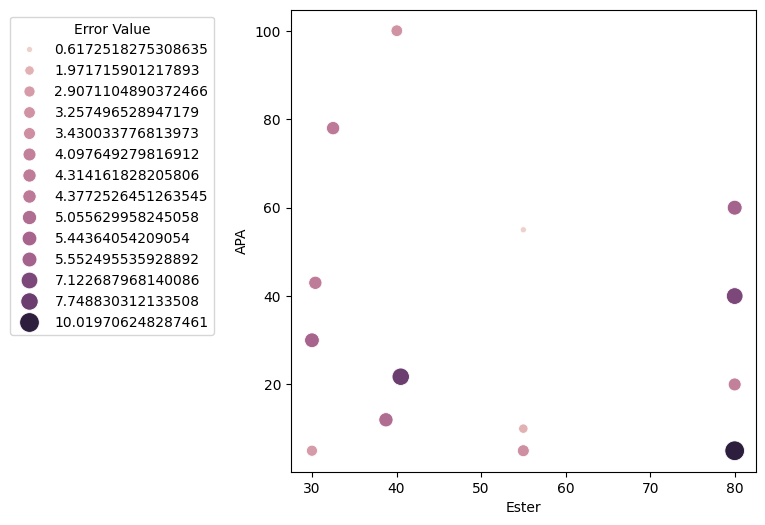

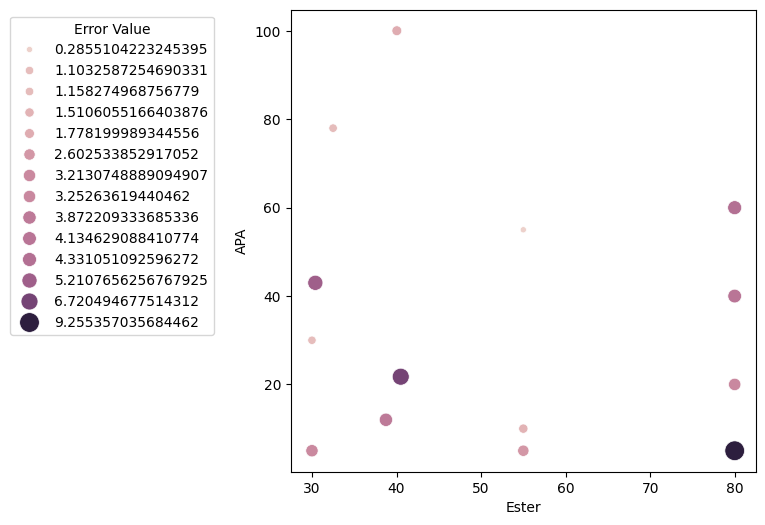

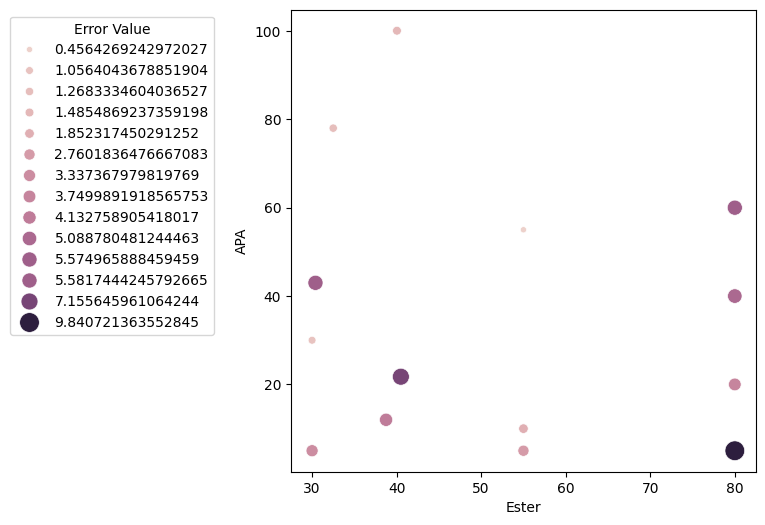

In [107]:
for method,p in zip(all_methods,all_par_sets):
    print()
    print(method)
    print()
    eval_all(p)

# Estimate both

In [108]:
def calculate_error_total(model_output, experimental_data,params):
    total_error = np.sum((model_output - experimental_data) ** 2)

    vel_error = calculate_error_all(params)*5000
    return total_error


In [109]:
def objective_function(params,errorfun):
    record.append(params)
    total_error = 0
    for df in data_frames_c:
        x_target = df.loc[:,x_names].to_numpy()
        t_target = df['apa_t'].to_numpy()
        ic = x_target[0]
        sol = ode15s_amox(params,ic,t_target)
        sol = sol.T
        total_error += errorfun(sol,x_target,params)
    print(total_error/len(data_frames_c),end="\r")
    all_error.append(total_error)
    return total_error


In [111]:
method = 'Nelder-Mead'
numiter = 3000
options = {'maxiter': numiter}
record = []
all_error = []
boundaries = [(0.0001,3), # Kcat1
                (0.0001,3), # Kcat2
                (0.0001,20), # Km1
                (0.0001,20), # Km2
                (0,1), # Tmax
                (0.0001,50), # Ken
                (0.0001,5000), # kAB
                (0.0001,5000), # kAN
                (0.0001,5000), # kAOH
                (0.0001,5000), # kNH
                ]
result = minimize(objective_function, P_new, method=method,bounds=boundaries,options=options,args=(calculate_error_total))

# Optimized parameters
optimized_parameters = result.x
print("Optimized Parameters:", optimized_parameters)
P_new = optimized_parameters

KeyboardInterrupt: 

Total error: 39.483777783295324	mass error:270.7579381620113


(39.483777783295324, 270.7579381620113)

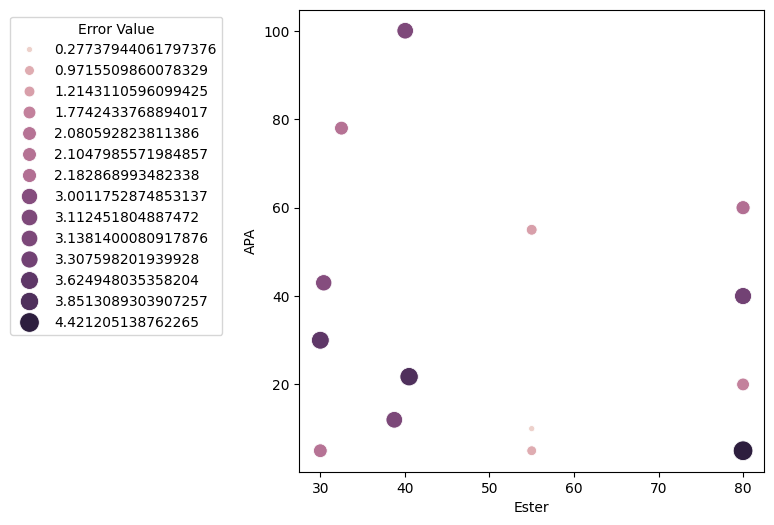

In [ ]:
eval_all(P_new)